In [1]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
from scipy.signal import hilbert, butter, filtfilt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pandas as pd
import random

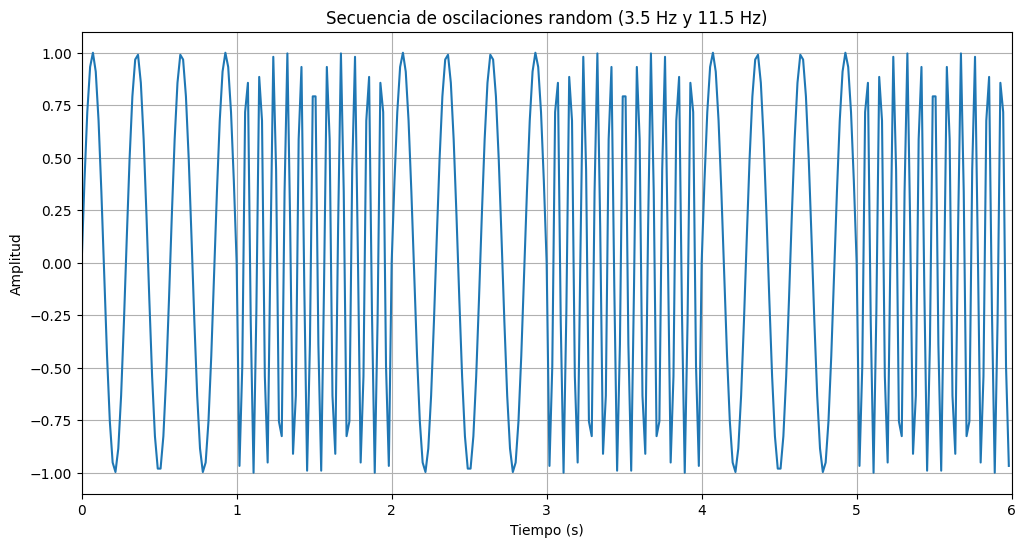

In [2]:
# Parámetros  
fs = 55            # Frecuencia de muestreo en Hz  
t_total = 6        # Duración total en segundos  
f1 = 3.5            # Frecuencia de la primera oscilación en Hz  
f2 = 11.5           # Frecuencia de la segunda oscilación en Hz  
duracion_segmento = 1  # Duración de cada segmento en segundos  
num_repeticiones = 6 # Número total de segmentos (3 de cada oscilacion) 

# vector de tiempo
t = np.arange(0, t_total, 1/fs) 

# Generamos las oscilaciones aleatorias   

amplitud = 1  # Amplitud aleatoria para la osc. 

# Inicializamos la secuencia  
secuencia = np.zeros_like(t)

# Llenar la secuencia con oscilaciones alternando  
for i in range(num_repeticiones):  
    if i % 2 == 0:  # Índices pares para la primera oscilación  
        start = i * duracion_segmento * fs  
        end = start + duracion_segmento * fs  
        secuencia[start:end] = amplitud  * np.sin(2 * np.pi * f1 * t[start:end])  
    else:  # Índices impares para la segunda oscilación  
        start = i * duracion_segmento * fs  
        end = start + duracion_segmento * fs  
        secuencia[start:end] = amplitud * np.sin(2 * np.pi * f2 * t[start:end])
# Graficar la señal  
plt.figure(figsize=(12, 6))  
plt.plot(t, secuencia)  
plt.title('Secuencia de oscilaciones random (3.5 Hz y 11.5 Hz)')  
plt.xlabel('Tiempo (s)')  
plt.ylabel('Amplitud')  
plt.xlim(0, t_total)  
plt.grid()  
plt.show()

## Clásico

In [125]:
# Parámetros
num_input_channels = 1      # Dimensionalidad de entrada (1 canal)
num_reservoir_neurons = 10   # Número de neuronas en el reservorio
num_readout_neurons = 1      # Número de neuronas de salida

num_training_samples = t.shape[0] # Número de muestras de entrenamiento

# Generar pesos de entrada al reservorio
input2res = np.random.randn(num_reservoir_neurons, num_input_channels)

# Generar pesos recurrentes del reservorio
res2res = np.random.randn(num_reservoir_neurons, num_reservoir_neurons)

# Normalizar las columnas de los pesos recurrentes
res2res = res2res / np.linalg.norm(res2res, axis=0)

# Sesgo del reservorio
input_bias = np.random.rand(num_reservoir_neurons, 1)

sec = secuencia.reshape(1, len(secuencia))


# Estados iniciales del reservorio
#reservoir_states = np.zeros((num_reservoir_neurons, num_training_samples + 1))
reservoir_states = np.random.randn(num_reservoir_neurons,num_training_samples + 1);

# Dinámicas del reservorio
for i in range(num_training_samples):
    reservoir_states[:, i + 1] = np.tanh(
        #(0.05 * input2res @ secuencia[i, np.newaxis]) +
        (0.05 * input2res @ sec[:, i]) +
        (0.95 * res2res @ reservoir_states[:, i]) +
        input_bias.flatten()
    )

# Extracción de la envolvente superior usando Hilbert transform
RS = reservoir_states - np.mean(reservoir_states,axis=1, keepdims=True)
print(RS.shape)
analytic_signal = hilbert(RS)
amplitude_envelope = np.abs(analytic_signal)

print(analytic_signal.shape)
print(RS.shape)
print(amplitude_envelope.shape)

(10, 331)
(10, 331)
(10, 331)
(10, 331)


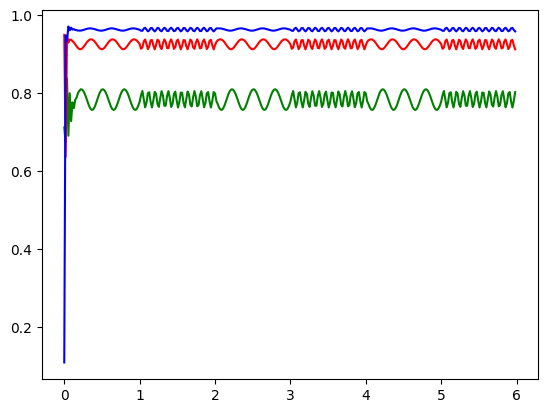

In [6]:
plt.plot(t, reservoir_states[0, 1:], color = 'green')
plt.plot(t, reservoir_states[1, 1:], color = 'red')
plt.plot(t, reservoir_states[2, 1:], color = 'blue')
plt.show()

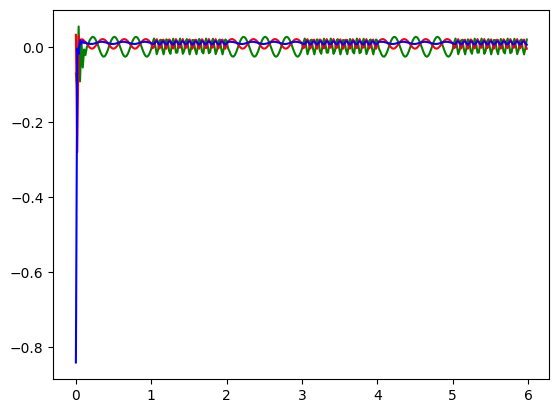

In [7]:
plt.plot(t, RS[0, 1:], color = 'green')
plt.plot(t, RS[1, 1:], color = 'red')
plt.plot(t, RS[2, 1:], color = 'blue')
plt.show()

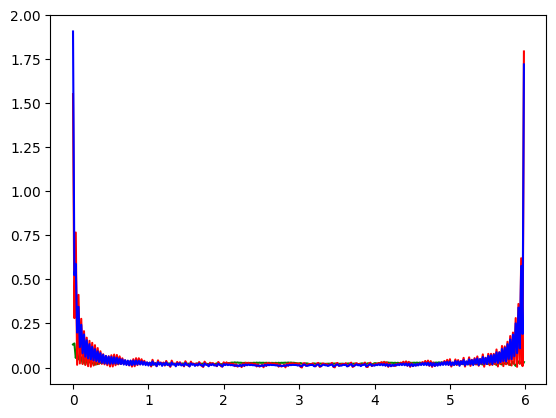

In [8]:
plt.plot(t, amplitude_envelope[0, 1:], color = 'green')
plt.plot(t, amplitude_envelope[1, 1:], color = 'red')
plt.plot(t, amplitude_envelope[2, 1:], color = 'blue')
plt.show()

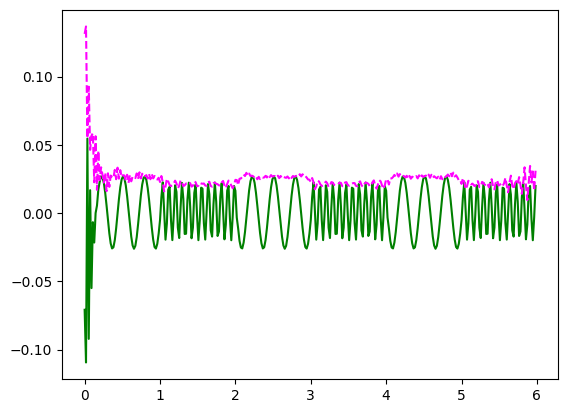

In [9]:
plt.plot(t, RS[0, 1:], color = 'green')
plt.plot(t, amplitude_envelope[0, 1:], linestyle="dashed", color = 'magenta')
plt.show()

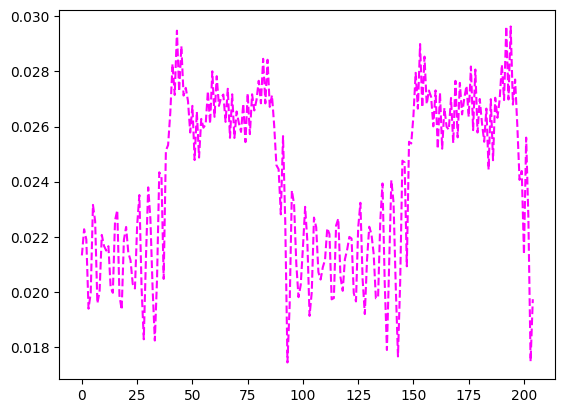

In [10]:
# Eliminamos los primeros 75 puntos para estabilizar el reservorio
stable_start = min(75, amplitude_envelope.shape[1])
input_sequence = amplitude_envelope[:, stable_start:-50]
plt.plot(input_sequence[0, 1:], linestyle="dashed", color = 'magenta')
plt.show()

In [11]:
# Agrupamiento (clustering)
num_clusters = 2  # Número de clústeres
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(input_sequence.T)

# Resultados
idx = kmeans.labels_  # Etiquetas de los clústeres
C = kmeans.cluster_centers_  # Centroides de los clústeres

print("Centroides de los clústeres:")
print(C)
print(idx.shape)

Centroides de los clústeres:
[[0.02125755 0.01804429 0.01447784 0.02741244 0.01338447 0.01398734
  0.07666358 0.02563737 0.02614749 0.01825166]
 [0.02645044 0.01917164 0.01519202 0.02219067 0.02480982 0.02239692
  0.05793422 0.02879881 0.01451134 0.01512445]]
(206,)


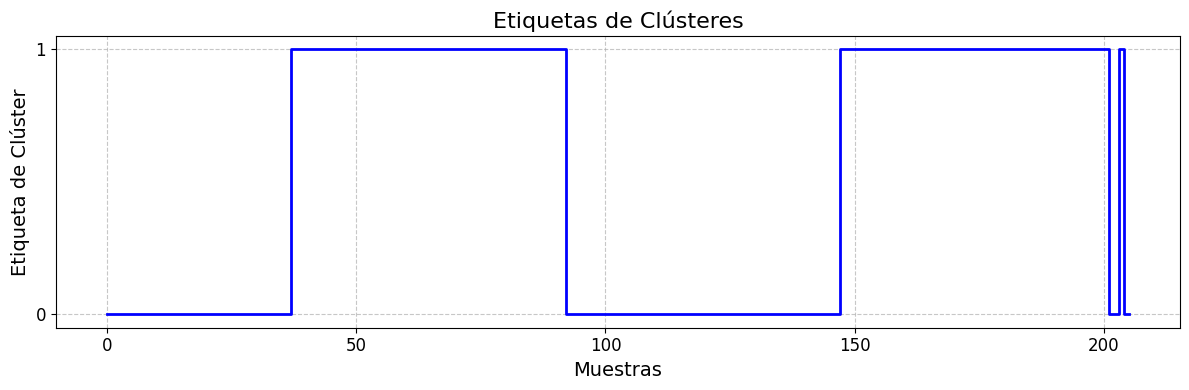

In [12]:
plt.figure(figsize=(12, 4))  
plt.step(range(input_sequence.shape[1]), idx, where='post', color='blue', linewidth=2) 
plt.title('Etiquetas de Clústeres', fontsize=16)
plt.xlabel('Muestras', fontsize=14)  
plt.ylabel('Etiqueta de Clúster', fontsize=14)  
plt.yticks(np.arange(num_clusters))  
plt.xticks(fontsize=12)  
plt.yticks(fontsize=12)  
plt.grid(True, linestyle='--', alpha=0.7)
#plt.xlim(100, 200)  
plt.tight_layout() 
plt.show()

## Cuántico

In [13]:
# Number of qubits (size of quantum reservoir)
num_qubits = 10
# Depth of the reservoir circuit
num_layers = 1  

# Create a quantum device (simulator)
dev = qml.device("default.qubit", wires=num_qubits)

In [14]:
def apply_RX(theta, state):  
    """Aplica la compuerta RX al estado dado en la qubit correspondiente."""  
    RX_matrix = np.array([[np.cos(theta / 2), -1j * np.sin(theta / 2)],  
                          [-1j * np.sin(theta / 2), np.cos(theta / 2)]])  
    # Numero total de qubits  
    dim = 2 ** num_qubits  
    
    # Crear una matriz identidad de dimensión total  
    full_matrix = np.eye(dim, dtype=complex)  
    
    # Insertar la matriz RX en la posición adecuada  
    for i in range(2 ** (num_qubits - 1)):  
        full_matrix[2*i, 2*i] = RX_matrix[0, 0]  
        full_matrix[2*i, 2*i + 1] = RX_matrix[0, 1]  
        full_matrix[2*i + 1, 2*i] = RX_matrix[1, 0]  
        full_matrix[2*i + 1, 2*i + 1] = RX_matrix[1, 1]  

    return np.dot(full_matrix, state) 

def apply_CNOT(state, control_index, target_index):  
    """Aplica la compuerta CNOT entre dos qubits en el estado dado."""  
    dim = 2 ** num_qubits  
    CNOT_matrix = np.eye(dim, dtype=complex)  
    # Crear la matriz CNOT  
    for i in range(dim):  
        binary = f"{i:0{num_qubits}b}"  
        control_qubit = int(binary[control_index])  # Estado del qubit de control  
        target_qubit = int(binary[target_index])     # Estado del qubit objetivo  

        # Si el qubit de control es 1, hacemos flip en el objetivo  
        if control_qubit == 1:  
            new_target_qubit = target_qubit ^ 1  # Flip  
            new_value = i & ~(1 << target_index) | (new_target_qubit << target_index)  
            CNOT_matrix[new_value, i] = 1  # Mover probabilidad de qubit viejo a nuevo  

    return np.dot(CNOT_matrix, state)  

def quantum_reservoir(reservoir_weights, num_qubits, initial_states):  
    """Quantum Reservoir con compuertas CNOT y rotaciones."""
    # Aplicar rotaciones y CNOTs    
    states = []
    for i in range(num_qubits):  
        # Rotación aleatoria en cada qubit  
        theta = reservoir_weights[i, i]
        state = apply_RX(theta, initial_states[i])  
        # Entrelazamiento con el siguiente qubit (circular)  
        target_qubit = (i + 1) % num_qubits  
        state = apply_CNOT(state, i, target_qubit) 
        states.append(state) 

    return states  

def compute_expectation_z(state):  
    """Calcula los valores de expectativa para cada qubit utilizando Z."""   
    dim = 2 ** num_qubits  # Dimensión total del espacio de Hilbert  

    # Iterar sobre cada qubit  
    for i in range(num_qubits):  
        # Crear la matriz Pauli-Z para el qubit i  
        Z_matrix = np.eye(dim, dtype=complex)  
        for j in range(dim):  
            binary = f"{j:0{num_qubits}b}"  
            # Si el qubit i es 1, cambia el signo  
            if binary[i] == '1':  
                Z_matrix[j, j] = -1  # Cambio de signo  

        # Calcular la expectativa  
        expectation_value = np.dot(state.conj().T, np.dot(Z_matrix, state)).real

    return expectation_value 

In [15]:
# Definir el Quantum Reservoir  
def quantum_reservoir(reservoir_weights):  
    """Quantum Reservoir con compuertas CNOT y rotaciones."""    
    for i in range(num_qubits):
         for j in range(num_qubits):
            # Rotación aleatoria en cada qubit  
            qml.RX(reservoir_weights[i,j], wires= i)
            # Entrelazamiento con el siguiente qubit (circular)  
            control_qubit = i 
            target_qubit = (i + 1) % num_qubits  
            qml.CNOT(wires=[control_qubit, target_qubit])

In [16]:
# Define Quantum Node
@qml.qnode(dev)
def quantum_echo_state_network(input_data, prev_output, weights_in, weights_rc, reservoir_weights):
    """Quantum Echo State Network (QESN)"""
    # Encode input and previous output into qubits
    for i in range(num_qubits):
        qml.RX(.05*weights_in[i] * input_data + .95*weights_rc[i] * prev_output[i], wires=i)
    
    # Evolve through the quantum reservoir
    quantum_reservoir(reservoir_weights)
    
    # Measure expectation values (output features)
    return [qml.expval(qml.PauliZ(i)) for i in range(num_qubits)]

In [17]:
# Initialize parameters
weights_in = np.random.uniform(-np.pi, np.pi, num_qubits)
weights_rc = np.random.uniform(-np.pi, np.pi, num_qubits)
#reservoir_weights = np.random.uniform(-np.pi, np.pi, (num_qubits, num_qubits))
reservoir_weights = np.random.uniform(-np.pi, np.pi, (num_qubits, num_qubits))

sec = secuencia.reshape(1, len(secuencia))
input_series = sec
time_steps = input_series.shape[1]

# Run QESN
outputs = np.zeros((num_qubits, time_steps))
prev_output = np.zeros(num_qubits)  # Initial output

for t0 in range(time_steps):
    q_output = quantum_echo_state_network(input_series[:, t0], prev_output, weights_in, weights_rc, reservoir_weights)
    final_output = np.tanh(q_output)  # Apply tanh non-linearity

    # Almacenar el resultado en la lista
    outputs[:, t0] = np.array(final_output).squeeze()
    #outputs.append(final_output)
    prev_output = final_output  # Recurrent connection
    print(f"Step {t0}: {outputs[:, t0]}")

Step 0: [-0.02581926 -0.04891951 -0.37473145 -0.1026095   0.00132509  0.01754166
  0.25262472 -0.20474358  0.04809565 -0.23036051]
Step 1: [-0.0263545  -0.04840277 -0.40860575 -0.09585812  0.00130885  0.01796232
  0.18695564 -0.20394162  0.05986586 -0.25239829]
Step 2: [-0.02581372 -0.05074754 -0.40878299 -0.09851075  0.00130609  0.01796794
  0.21249602 -0.20308796  0.06458017 -0.25365117]
Step 3: [-0.02540611 -0.05204838 -0.40868191 -0.09955863  0.00130421  0.01796512
  0.20913865 -0.20246532  0.06712103 -0.25391607]
Step 4: [-0.02526387 -0.05241504 -0.40863646 -0.09986607  0.00130363  0.01796413
  0.21140348 -0.20227208  0.06809954 -0.2539886 ]
Step 5: [-0.02541929 -0.05179545 -0.4086935  -0.09930723  0.00130443  0.01796534
  0.20903433 -0.20257017  0.06754815 -0.25390215]
Step 6: [-0.02584112 -0.05024403 -0.40879669 -0.09795033  0.0013065   0.01796858
  0.20528002 -0.20325752  0.06557944 -0.25364698]
Step 7: [-0.02644548 -0.04792549 -0.40882509 -0.09596004  0.0013095   0.01797333
  

In [18]:
print(outputs.shape)
print(t.shape)

(10, 330)
(330,)


(10, 330)


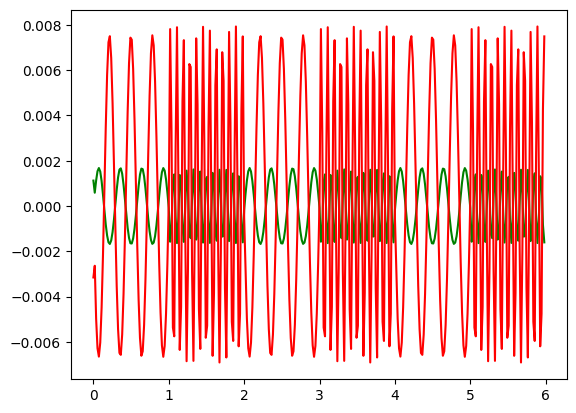

In [19]:
# Extracción de la envolvente superior usando Hilbert transform
RS_cuantico = outputs - np.mean(outputs,axis=1, keepdims=True)
print(RS_cuantico.shape)

plt.plot(t, RS_cuantico[0, :], color = 'green')
plt.plot(t, RS_cuantico[1, :], color = 'red')
plt.show()

In [20]:
# Función para aplicar un filtro pasa-banda
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

# Parámetros
fs = 55  # Frecuencia de muestreo
lowcut = 1  # Frecuencia baja del filtro
highcut = 12  # Frecuencia alta del filtro

# Aplicar filtro antes de Hilbert
x_filtered = bandpass_filter(RS_cuantico, lowcut, highcut, fs)

In [21]:
analytic_signal = hilbert(x_filtered)
amplitude_envelope = np.abs(analytic_signal)
print(analytic_signal.shape)
print(amplitude_envelope.shape)

(10, 330)
(10, 330)


C:\Users\Yolanda\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\Yolanda\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


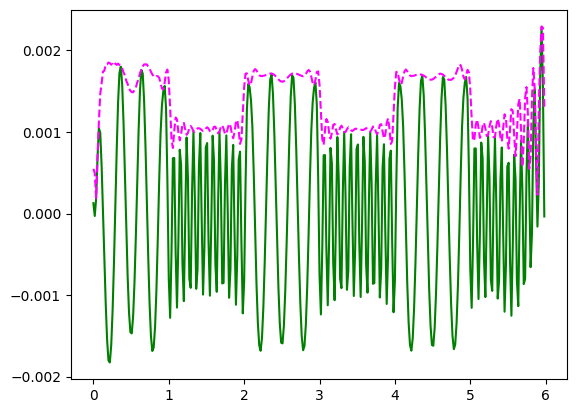

In [22]:
plt.plot(t, analytic_signal[0, :], color = 'green')
plt.plot(t, amplitude_envelope[0, :], linestyle="dashed", color = 'magenta')
plt.show()

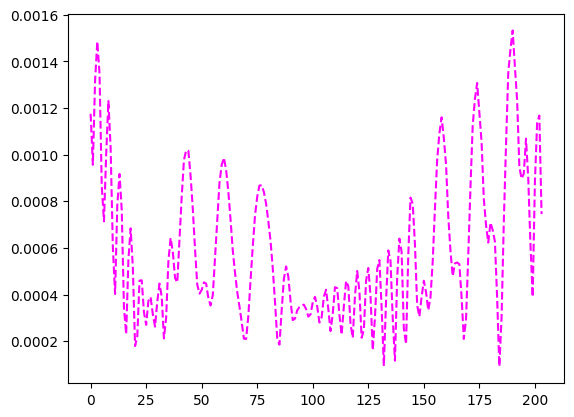

In [23]:
stable_start = min(75, amplitude_envelope.shape[1])
input_sequence = amplitude_envelope[:, stable_start:-50]
plt.plot(input_sequence[2, 1:], linestyle="dashed", color = 'magenta')
plt.show()

In [24]:
# Agrupamiento (clustering)
num_clusters = 2  # Número de clústeres
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(input_sequence.T)

# Resultados
idx = kmeans.labels_  # Etiquetas de los clústeres
C = kmeans.cluster_centers_  # Centroides de los clústeres

print("Centroides de los clústeres:")
print(C)
print(idx.shape)

Centroides de los clústeres:
[[1.02944116e-03 4.68492386e-03 5.01663245e-04 3.99508956e-03
  5.59338141e-06 9.97449420e-06 1.08725174e-02 1.19811683e-03
  5.35170540e-03 1.05313704e-03]
 [1.68509561e-03 7.11373536e-03 6.72327721e-04 5.98782690e-03
  8.81413139e-06 1.45071955e-05 1.50982708e-02 1.90298574e-03
  9.70993818e-03 1.67622257e-03]]
(205,)


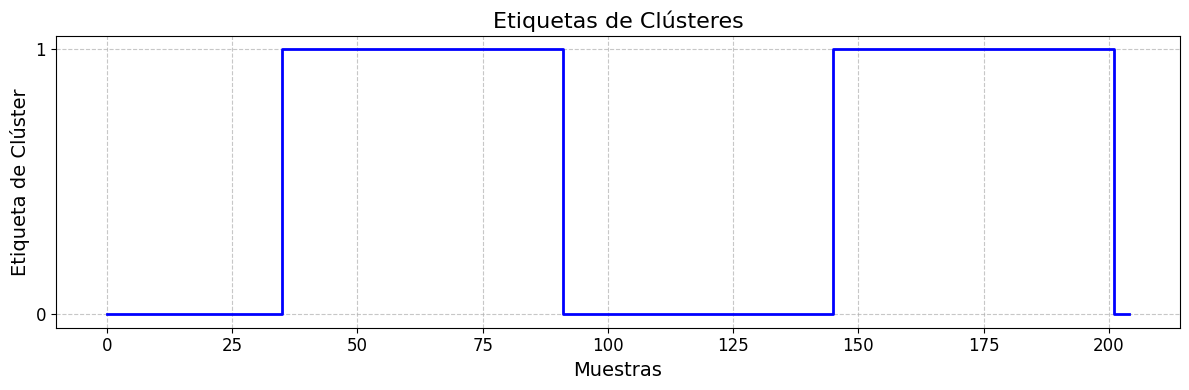

In [25]:
plt.figure(figsize=(12, 4))  
plt.step(range(input_sequence.shape[1]), idx, where='post', color='blue', linewidth=2) 
plt.title('Etiquetas de Clústeres', fontsize=16)
plt.xlabel('Muestras', fontsize=14)  
plt.ylabel('Etiqueta de Clúster', fontsize=14)  
plt.yticks(np.arange(num_clusters))  
plt.xticks(fontsize=12)  
plt.yticks(fontsize=12)  
plt.grid(True, linestyle='--', alpha=0.7)
#plt.xlim(100, 200)  
plt.tight_layout() 
plt.show()

## Señal senoidal más compleja(implementación clásica).

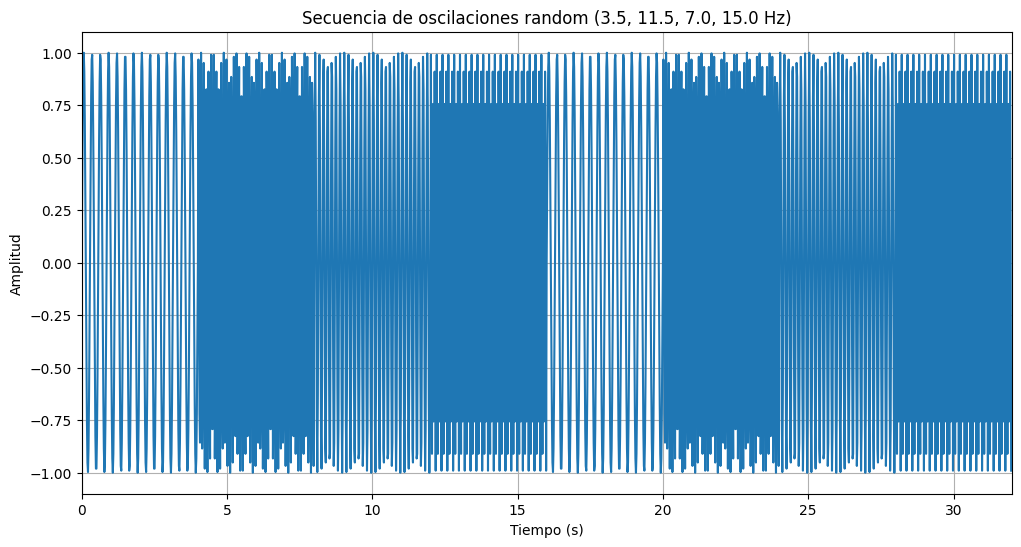

In [127]:
# Parámetros  
fs = 55            # Frecuencia de muestreo en Hz  
t_total = 32        # Duración total en segundos  
frecuencias = [3.5, 11.5, 7.0, 15.0]  # Cuatro frecuencias en Hz  
duracion_segmento = 4  # Duración de cada segmento en segundos  
num_repeticiones = 2 # 3 repeticiones = 12 segundos 

# Inicializamos la secuencia final como una lista  
secuencia2 = []  
amplitud = 1  

# Bucle externo para repetir el ciclo completo  
for i in range(num_repeticiones):  
    # Bucle interno para iterar sobre cada frecuencia en el ciclo  
    for frecuencia_idx in range(len(frecuencias)):  
        # Calcular el tiempo para el segmento actual  
        tiempo_segmento = np.arange(0, duracion_segmento, 1/fs)  
        
        # Calcular la frecuencia basada en el índice del segmento  
        frecuencia_actual = frecuencias[frecuencia_idx]  

        # Generar la oscilación según la frecuencia correspondiente  
        oscilacion = amplitud * np.sin(2 * np.pi * frecuencia_actual * tiempo_segmento)  

        secuencia2.extend(oscilacion)  # Añadir el segmento a la secuencia  

# Convertir la secuencia a un arreglo numpy para facilitar su manejo  
secuencia2 = np.array(secuencia2) 

# Crear el tiempo correspondiente a la secuencia  
t2 = np.arange(0, len(secuencia2)/fs , 1/fs)

# Graficar la señal  
plt.figure(figsize=(12, 6))  
plt.plot(t2, secuencia2)  
plt.title('Secuencia de oscilaciones random (3.5, 11.5, 7.0, 15.0 Hz)')  
plt.xlabel('Tiempo (s)')  
plt.ylabel('Amplitud')  
plt.xlim(0, t_total)  
plt.grid()  
plt.show()

In [183]:
# Parámetros
num_input_channels = 1      # Dimensionalidad de entrada (1 canal)
num_reservoir_neurons = 20   # Número de neuronas en el reservorio
num_readout_neurons = 1      # Número de neuronas de salida

num_training_samples = t2.shape[0] # Número de muestras de entrenamiento

# Generar pesos de entrada al reservorio
input2res = np.random.randn(num_reservoir_neurons, num_input_channels)

# Generar pesos recurrentes del reservorio
res2res = np.random.randn(num_reservoir_neurons, num_reservoir_neurons)

# Normalizar las columnas de los pesos recurrentes
res2res = res2res / np.linalg.norm(res2res, axis=0)

# Sesgo del reservorio
input_bias = np.random.rand(num_reservoir_neurons, 1)

sec2 = secuencia2.reshape(1, len(secuencia2))

# Estados iniciales del reservorio
#reservoir_states = np.zeros((num_reservoir_neurons, num_training_samples + 1))
reservoir_states = np.random.randn(num_reservoir_neurons,num_training_samples + 1);

# Dinámicas del reservorio
for i in range(num_training_samples):
    reservoir_states[:, i + 1] = np.tanh(
        (0.05 * input2res @ sec2[:, i]) +
        (0.95 * res2res @ reservoir_states[:, i]) +
        input_bias.flatten()
    )

# Extracción de la envolvente superior usando Hilbert transform
RS2 = reservoir_states - np.mean(reservoir_states,axis=1, keepdims=True)
print(RS2.shape)

# Función para aplicar un filtro pasa-banda
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

# Parámetros
fs = 55  # Frecuencia de muestreo
lowcut = 3.5  # Frecuencia baja del filtro
highcut = 15  # Frecuencia alta del filtro

# Aplicar filtro antes de Hilbert
x_filtered = bandpass_filter(RS2, lowcut, highcut, fs)

analytic_signal = hilbert(x_filtered)
amplitude_envelope2 = np.abs(analytic_signal)

print(analytic_signal.shape)
print(x_filtered.shape)
print(amplitude_envelope2.shape)

(20, 1761)
(20, 1761)
(20, 1761)
(20, 1761)


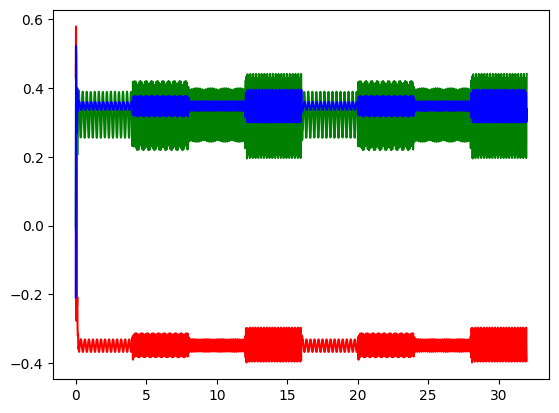

In [184]:
plt.plot(t2, reservoir_states[0, 1:], color = 'green')
plt.plot(t2, reservoir_states[1, 1:], color = 'red')
plt.plot(t2, reservoir_states[2, 1:], color = 'blue')
plt.show()

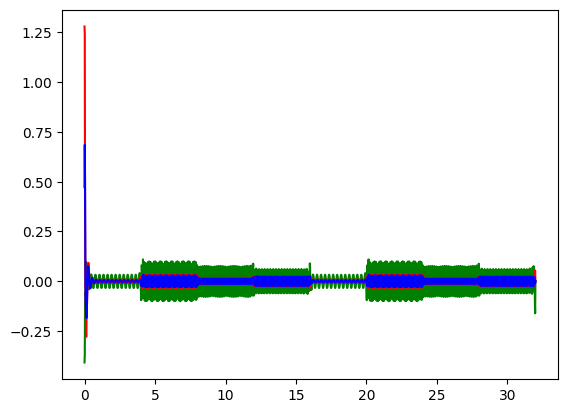

In [185]:
plt.plot(t2, x_filtered[0, 1:], color = 'green')
plt.plot(t2, x_filtered[1, 1:], color = 'red')
plt.plot(t2, x_filtered[2, 1:], color = 'blue')
plt.show()

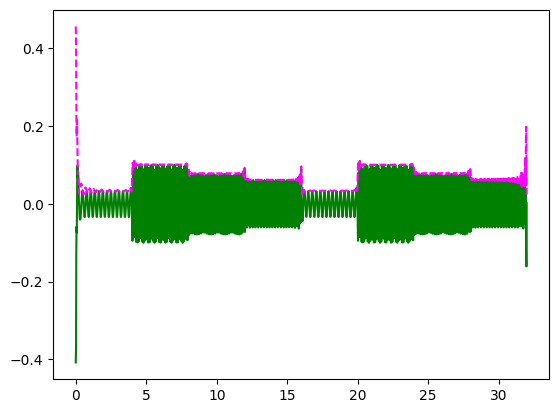

In [186]:
plt.plot(t2, x_filtered[0, 1:], color = 'green')
plt.plot(t2, amplitude_envelope2[0, 1:], linestyle="dashed", color = 'magenta')
plt.show()

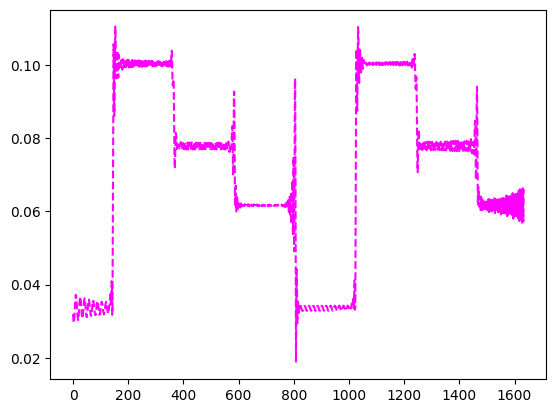

In [187]:
# Eliminamos los primeros puntos para estabilizar el reservorio
stable_start = min(75, amplitude_envelope2.shape[1])
input_sequence2 = amplitude_envelope2[:, stable_start:-50]
plt.plot(input_sequence2[0, 1:], linestyle="dashed", color = 'magenta')
plt.show()

In [188]:
# Agrupamiento (clustering)
num_clusters = 4  # Número de clústeres
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(input_sequence2.T)

# Resultados
idx = kmeans.labels_  # Etiquetas de los clústeres
C = kmeans.cluster_centers_  # Centroides de los clústeres

print("Centroides de los clústeres:")
print(C)
print(idx.shape)
print(input_sequence2.shape)

Centroides de los clústeres:
[[0.03385064 0.00945668 0.00621693 0.00758847 0.01211799 0.00472276
  0.00171739 0.0094688  0.0064421  0.02757909 0.01918558 0.00196655
  0.00727704 0.02930264 0.00657017 0.01675761 0.01558576 0.00828079
  0.00665751 0.0293164 ]
 [0.09997785 0.03446309 0.02956774 0.04379547 0.00694545 0.01232776
  0.01108221 0.03102769 0.00505849 0.02853536 0.0181807  0.00560056
  0.01770841 0.09638865 0.02987459 0.02626661 0.02266478 0.01685942
  0.0416952  0.05606932]
 [0.07805949 0.01857173 0.01424378 0.02099701 0.02221768 0.0064561
  0.00621823 0.02415974 0.00882498 0.05452577 0.03400595 0.00432657
  0.0163385  0.08303984 0.0179193  0.03250412 0.02774574 0.01714496
  0.02577375 0.06447932]
 [0.06179711 0.02530068 0.02426229 0.02706341 0.01447666 0.01000043
  0.00871641 0.01890942 0.00491602 0.01264095 0.00335787 0.003597
  0.01329292 0.04974954 0.02125417 0.00280576 0.0112824  0.00783023
  0.02861417 0.01982339]]
(1636,)
(20, 1636)


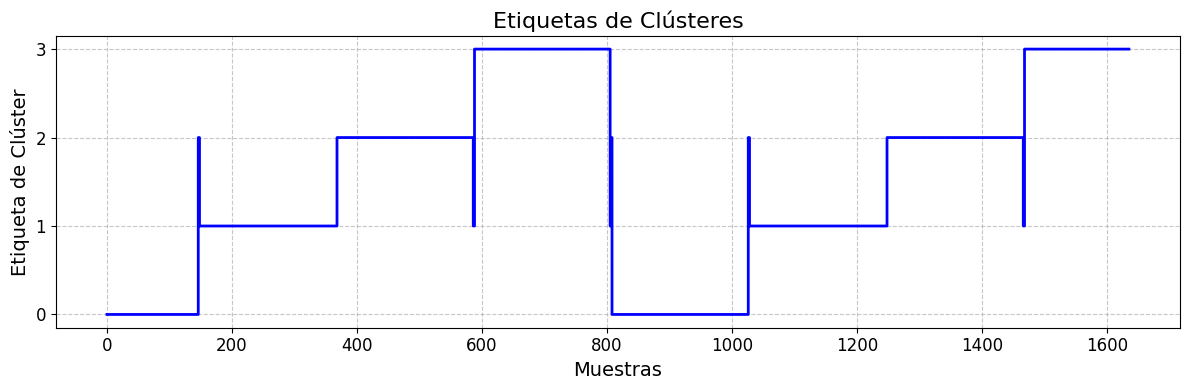

In [189]:
plt.figure(figsize=(12, 4))  
plt.step(range(input_sequence2.shape[1]), idx, where='post', color='blue', linewidth=2) 
plt.title('Etiquetas de Clústeres', fontsize=16)
plt.xlabel('Muestras', fontsize=14)  
plt.ylabel('Etiqueta de Clúster', fontsize=14)  
plt.yticks(np.arange(num_clusters))  
plt.xticks(fontsize=12)  
plt.yticks(fontsize=12)  
plt.grid(True, linestyle='--', alpha=0.7)
#plt.xlim(100, 200)  
plt.tight_layout() 
plt.show()

In [190]:
secuencia2.shape

(1760,)

In [191]:
stable_start = min(75, len(secuencia2))
secuencia22 = secuencia2[stable_start:-50]
secuencia22.shape

(1635,)

In [192]:
stable_start = min(75, len(t2))
t22 = t2[stable_start:-50]
t22.shape

(1635,)

In [193]:
idx.shape

(1636,)

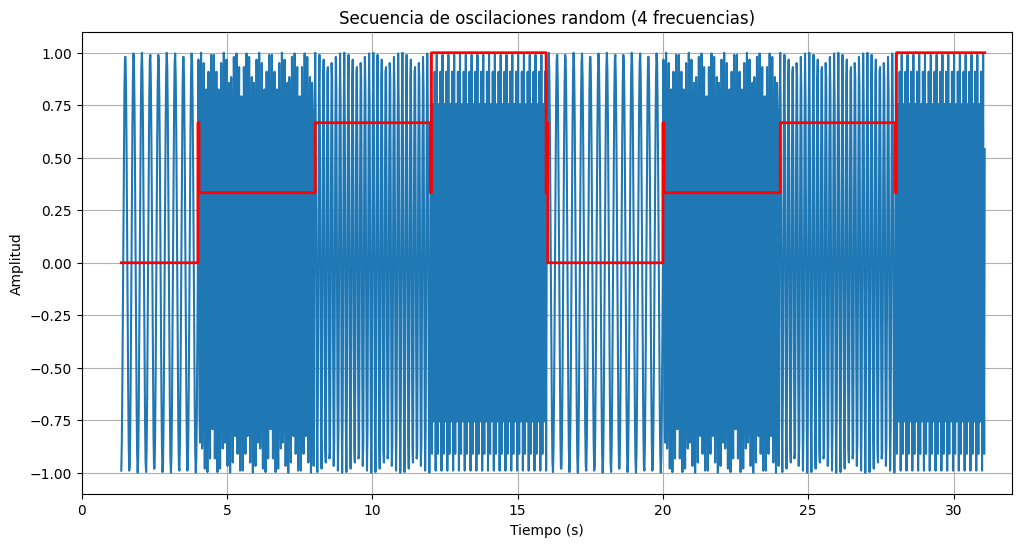

In [194]:
# Graficar la señal  
plt.figure(figsize=(12, 6))  
plt.plot(t22, secuencia22)
plt.step(t22, idx[1:]/3, where='post', color='red', linewidth=2) 
plt.title('Secuencia de oscilaciones random (4 frecuencias)')  
plt.xlabel('Tiempo (s)')  
plt.ylabel('Amplitud')  
plt.xlim(0, t_total)  
plt.grid()  
plt.show()

## Señal senoidal más compleja(implementación cuántica).

In [205]:
# Number of qubits (size of quantum reservoir)
num_qubits = 10
# Depth of the reservoir circuit
num_layers = 1  

# Create a quantum device (simulator)
dev = qml.device("default.qubit", wires=num_qubits)

In [206]:
# Definir el Quantum Reservoir  
def quantum_reservoir(reservoir_weights, connectivity):  
    """Quantum Reservoir con compuertas CNOT y rotaciones."""    
    for i in range(num_qubits):
         for j in range(num_qubits):
            # Rotación aleatoria en cada qubit  
            qml.RX(reservoir_weights[i,j], wires= i)
            
    # Aplicar entrelazamiento entre los qubits seleccionados.(conectividad limitada)
    if connectivity == 'ring':
        for j in range(num_qubits - 1):
            qml.CNOT(wires=[j, j+1])  # Apply entanglement between adjacent qubits
                     
                
    if connectivity == 'star':
    # Entangling the first qubit (central node) with all other qubits
        central_qubit = 0  # We use qubit 0 as the central node
        for j in range(1, num_qubits):
             qml.CNOT(wires=[central_qubit, j])
 
    if connectivity == 'random':
            # Crear pares de qubits aleatorios
              qubit_pairs = [(j, k) for j in range(num_qubits) for k in range(j + 1, num_qubits)]
              random.shuffle(qubit_pairs)
            # Entrelazar aleatoriamente
              for j, k in qubit_pairs[:num_qubits // 2]:
                  qml.CNOT(wires=[j, k])
 
    elif connectivity == 'full':
            # Full connectivity: entangle all pairs of qubits
              for j in range(num_qubits):
                 for k in range(j + 1, num_qubits):  # Loop over all pairs of qubits
                    qml.CNOT(wires=[j, k])  # Apply entanglement between qubit j and k        

In [215]:
# Define Quantum Node
@qml.qnode(dev)
def quantum_echo_state_network(input_data, prev_output, weights_in, weights_rc, reservoir_weights):
    """Quantum Echo State Network (QESN)"""
    # Encode input and previous output into qubits
    for i in range(num_qubits):
        qml.RX(.05*weights_in[i] * input_data + .95*weights_rc[i] * prev_output[i], wires=i)
    
    # Evolve through the quantum reservoir
    quantum_reservoir(reservoir_weights, connectivity='star')
    
    # Measure expectation values (output features)
    return [qml.expval(qml.PauliZ(i)) for i in range(num_qubits)]

In [216]:
# Initialize parameters
weights_in = np.random.uniform(-np.pi, np.pi, num_qubits)
weights_rc = np.random.uniform(-np.pi, np.pi, num_qubits)
#reservoir_weights = np.random.uniform(-np.pi, np.pi, (num_qubits, num_qubits))
reservoir_weights = np.random.uniform(-np.pi, np.pi, (num_qubits, num_qubits))

sec2 = secuencia2.reshape(1, len(secuencia2))
input_series = sec2
time_steps = input_series.shape[1]

# Run QESN
outputs = np.zeros((num_qubits, time_steps))
prev_output = np.zeros(num_qubits)  # Initial output

for t0 in range(time_steps):
    q_output = quantum_echo_state_network(input_series[:, t0], prev_output, weights_in, weights_rc, reservoir_weights)
    final_output = np.tanh(q_output)  # Apply tanh non-linearity

    # Almacenar el resultado en la lista
    outputs[:, t0] = np.array(final_output).squeeze()
    prev_output = final_output  # Recurrent connection
    print(f"Step {t0}: {outputs[:, t0]}")

Step 0: [ 0.61817525  0.44074032  0.47508571  0.4919868  -0.33388523 -0.52126846
  0.16925982 -0.54636756 -0.61075122  0.04386268]
Step 1: [-0.68457059  0.3172584  -0.40507088 -0.67265518  0.64922762  0.58409559
 -0.4602073   0.67100701 -0.23261641 -0.13389268]
Step 2: [ 0.3688165  -0.03633076  0.33522719  0.00408534  0.31634794  0.20245951
 -0.31048826 -0.20517563 -0.26946029 -0.04509865]
Step 3: [-0.28801504 -0.20902264 -0.18423675 -0.19614249 -0.09060649  0.11145371
  0.16984647  0.25672337  0.19056245 -0.01420492]
Step 4: [ 0.76153168  0.73684284  0.68982377  0.44906392 -0.49073354 -0.51873486
  0.50531514 -0.61699412 -0.72094743  0.10422543]
Step 5: [-0.75747877  0.7194276  -0.41029108 -0.73223388  0.75446381  0.66715508
 -0.75406712  0.74606612 -0.47848037 -0.28371602]
Step 6: [ 0.18228791 -0.16365236  0.16451178 -0.00931618  0.17220853  0.12701107
 -0.18038775 -0.09203344 -0.01932001 -0.06709148]
Step 7: [ 0.25636933  0.2322825   0.17266939  0.18440081 -0.02137282 -0.14659453
 -

(10, 1760)


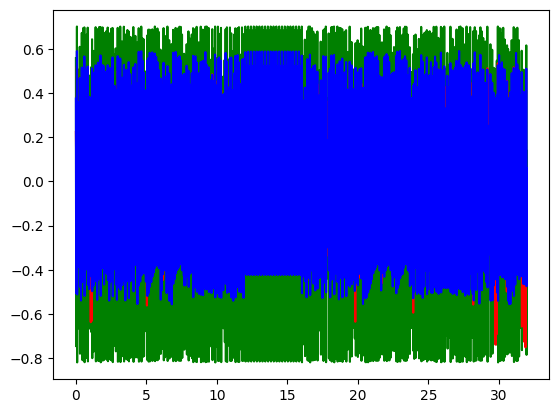

In [217]:
# Extracción de la envolvente superior usando Hilbert transform
RS_cuantico_2 = outputs - np.mean(outputs,axis=1, keepdims=True)
print(RS_cuantico_2.shape)

plt.plot(t2, RS_cuantico_2[0, :], color = 'green')
plt.plot(t2, RS_cuantico_2[1, :], color = 'red')
plt.plot(t2, RS_cuantico_2[2, :], color = 'blue')
plt.show()

In [218]:
# Función para aplicar un filtro pasa-banda
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

# Parámetros
fs = 55  # Frecuencia de muestreo
lowcut = 3.5  # Frecuencia baja del filtro
highcut = 15  # Frecuencia alta del filtro

# Aplicar filtro antes de Hilbert
x_filtered = bandpass_filter(RS_cuantico_2, lowcut, highcut, fs)

In [219]:
analytic_signal = hilbert(x_filtered)
amplitude_envelope = np.abs(analytic_signal)
print(analytic_signal.shape)
print(amplitude_envelope.shape)

(10, 1760)
(10, 1760)


(10, 1635)


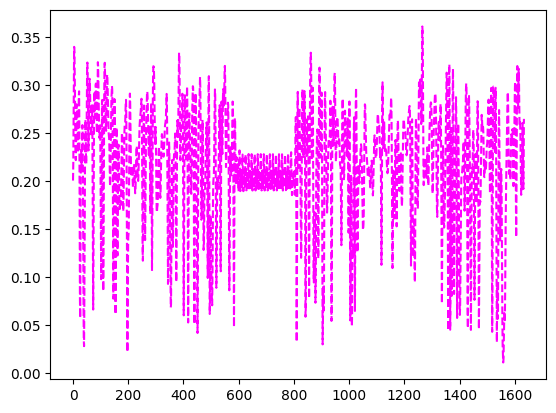

In [220]:
stable_start = min(75, amplitude_envelope.shape[1])
input_sequence = amplitude_envelope[:, stable_start:-50]
print(input_sequence.shape)
plt.plot(input_sequence[0, 1:], linestyle="dashed", color = 'magenta')
plt.show()

In [221]:
# Agrupamiento (clustering)
num_clusters = 4  # Número de clústeres
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(input_sequence.T)

# Resultados
idx = kmeans.labels_  # Etiquetas de los clústeres
C = kmeans.cluster_centers_  # Centroides de los clústeres

print("Centroides de los clústeres:")
print(C)
print(idx.shape)

Centroides de los clústeres:
[[0.12004082 0.10721101 0.05243315 0.17259029 0.20063322 0.23359875
  0.14910463 0.13887619 0.09963033 0.03417852]
 [0.22846313 0.25551001 0.10807268 0.26618457 0.22990364 0.29448268
  0.20288396 0.24398071 0.26816873 0.0574002 ]
 [0.16142457 0.23543754 0.09167525 0.19884496 0.35923926 0.25256214
  0.43981012 0.17325382 0.18699823 0.08203696]
 [0.26541677 0.28676827 0.14057904 0.3072234  0.33959077 0.33670271
  0.3157094  0.28096648 0.25789038 0.06533379]]
(1635,)


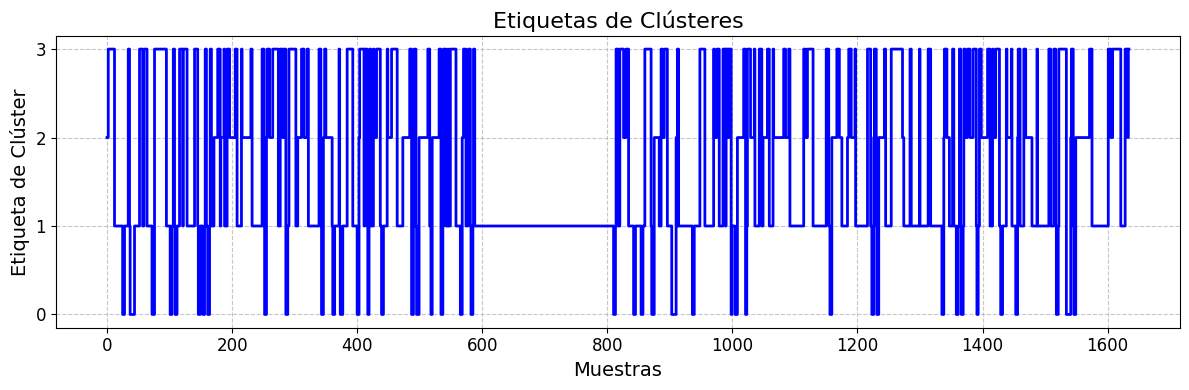

In [222]:
plt.figure(figsize=(12, 4))  
plt.step(range(input_sequence.shape[1]), idx, where='post', color='blue', linewidth=2) 
plt.title('Etiquetas de Clústeres', fontsize=16)
plt.xlabel('Muestras', fontsize=14)  
plt.ylabel('Etiqueta de Clúster', fontsize=14)  
plt.yticks(np.arange(num_clusters))  
plt.xticks(fontsize=12)  
plt.yticks(fontsize=12)  
plt.grid(True, linestyle='--', alpha=0.7)
#plt.xlim(100, 200)  
plt.tight_layout() 
plt.show()

## EEG reales.

In [154]:
# Carga de datos.
eeg_young = np.load("./data/data/dataset_Younger.npy")
eeg_old = np.load("./data/data/dataset_Older.npy")

FileNotFoundError: [Errno 2] No such file or directory: './data/data/dataset_Younger.npy'

In [ ]:
eeg_young.shape

In [ ]:
# Cogemos la señal de un canal de un sujeto joven.
muestra = eeg_young[0,:,:]

plt.plot(range(muestra.shape[0]), muestra[:,0], color = 'blue')
plt.show()

In [ ]:
muestra2 = muestra[:,0:10]
muestra2.shape

In [ ]:
# Implementación reservoir clásico con esta muestra.

# Parámetros
num_input_channels = 10      # Dimensionalidad de entrada (1 canal)
num_reservoir_neurons = 30   # Número de neuronas en el reservorio
num_readout_neurons = 1      # Número de neuronas de salida

num_training_samples = muestra2.shape[0] # Número de muestras de entrenamiento

# Generar pesos de entrada al reservorio
input2res = np.random.randn(num_reservoir_neurons, num_input_channels)

# Generar pesos recurrentes del reservorio
res2res = np.random.randn(num_reservoir_neurons, num_reservoir_neurons)

# Normalizar las columnas de los pesos recurrentes
res2res = res2res / np.linalg.norm(res2res, axis=0)

# Sesgo del reservorio
input_bias = np.random.rand(num_reservoir_neurons, 1)

# Estados iniciales del reservorio
#reservoir_states = np.zeros((num_reservoir_neurons, num_training_samples + 1))
reservoir_states = np.random.randn(num_reservoir_neurons,num_training_samples + 1);

# Dinámicas del reservorio
for i in range(num_training_samples):
    reservoir_states[:, i + 1] = np.tanh(
        (0.05 * input2res @ muestra2[i,:]) +
        (0.95 * res2res @ reservoir_states[:, i]) +
        input_bias.flatten()
    )

# Extracción de la envolvente superior usando Hilbert transform
RS3 = reservoir_states - np.mean(reservoir_states,axis=1, keepdims=True)
print(RS3.shape)
analytic_signal = hilbert(RS3)
amplitude_envelope3 = np.abs(analytic_signal)

print(analytic_signal.shape)
print(RS3.shape)
print(amplitude_envelope3.shape)

In [ ]:
plt.plot(range(muestra.shape[0]), RS3[0, 1:], color = 'green')
plt.plot(range(muestra.shape[0]), RS3[1, 1:], color = 'red')
plt.plot(range(muestra.shape[0]), RS3[2, 1:], color = 'blue')
plt.show()

In [ ]:
# Eliminamos los primeros puntos para estabilizar el reservorio
stable_start = min(100, amplitude_envelope3.shape[1])
input_sequence3 = amplitude_envelope3[:, stable_start:-50]
plt.plot(input_sequence3[0, 1:], linestyle="dashed", color = 'magenta')
plt.show()

In [ ]:
# Agrupamiento (clustering)
num_clusters = 4  # Número de clústeres
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(input_sequence3.T)

# Resultados
idx = kmeans.labels_  # Etiquetas de los clústeres
C = kmeans.cluster_centers_  # Centroides de los clústeres

print("Centroides de los clústeres:")
print(C)
print(idx.shape)

In [ ]:
plt.figure(figsize=(12, 4))  
plt.step(range(input_sequence3.shape[1]), idx, where='post', color='blue', linewidth=2) 
plt.title('Etiquetas de Clústeres', fontsize=16)
plt.xlabel('Muestras', fontsize=14)  
plt.ylabel('Etiqueta de Clúster', fontsize=14)  
plt.yticks(np.arange(num_clusters))  
plt.xticks(fontsize=12)  
plt.yticks(fontsize=12)  
plt.grid(True, linestyle='--', alpha=0.7)  
#plt.xlim([0,400])
plt.tight_layout() 
plt.show()

In [ ]:
# Encontrar el número de estados del cerebro

silhouette_scores = []  
clusters_range = range(2, 5)  # Clústeres de 2 a 4  
labels_clusters = []

for num_clusters in clusters_range:  
    kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(input_sequence3.T)  
    labels = kmeans.labels_  
    labels_clusters.append(labels)
    silhouette_avg = silhouette_score(input_sequence3.T, labels)  
    silhouette_scores.append(silhouette_avg)  
    print(f'Número de clústeres: {num_clusters}, Coeficiente Silhouette: {silhouette_avg:.4f}')  

# Graficar los resultados  
plt.figure(figsize=(8, 5))  
plt.plot(clusters_range, silhouette_scores, marker='o')  
plt.title('Coeficiente Silhouette para diferentes números de clústeres')  
plt.xlabel('Número de clústeres')  
plt.ylabel('Coeficiente Silhouette')  
plt.xticks(clusters_range)  
plt.grid()  
plt.show() 

## EEG simulados.

### Versión clásica.

In [155]:
synthetic_data = np.load('synthetic_data_auto.npy')
synthetic_data.shape

(40, 2000, 10)

In [156]:
muestra_synt = synthetic_data[0,:,:]
muestra_synt2 = synthetic_data[1,:,:]

In [157]:
# Reescalar la señal  
# Definimos el nuevo rango de -1 a 1.
min_val = -1  
max_val = 1  

# Calcular el rango original  
original_min = np.min(muestra_synt)  
original_max = np.max(muestra_synt)  

# Reescalar la señal  
scaled_signal = (muestra_synt - original_min) / (original_max - original_min) * (max_val - min_val) + min_val 

scaled_signal.shape

(2000, 10)

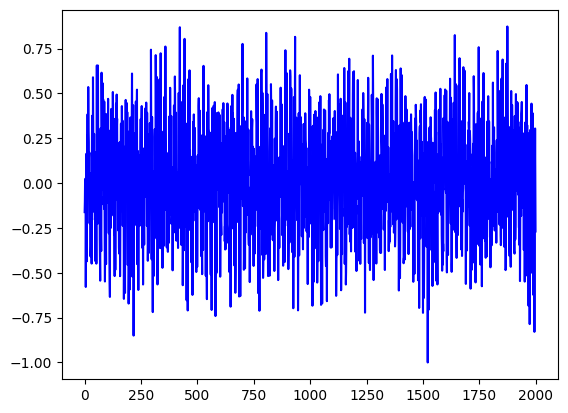

In [158]:
plt.plot(range(scaled_signal.shape[0]), scaled_signal[:,0], color = 'blue')
plt.show()

In [159]:
# Implementación reservoir clásico con EEG simulados.

# Parámetros
num_input_channels = 10      # Dimensionalidad de entrada (1 canal)
num_reservoir_neurons = 20   # Número de neuronas en el reservorio
num_readout_neurons = 1      # Número de neuronas de salida

num_training_samples = scaled_signal.shape[0] # Número de muestras de entrenamiento

# Generar pesos de entrada al reservorio
input2res = np.random.randn(num_reservoir_neurons, num_input_channels)

# Generar pesos recurrentes del reservorio
res2res = np.random.randn(num_reservoir_neurons, num_reservoir_neurons)

# Normalizar las columnas de los pesos recurrentes
res2res = res2res / np.linalg.norm(res2res, axis=0)

# Sesgo del reservorio
input_bias = np.random.rand(num_reservoir_neurons, 1)

# Estados iniciales del reservorio
#reservoir_states = np.zeros((num_reservoir_neurons, num_training_samples + 1))
reservoir_states = np.random.randn(num_reservoir_neurons,num_training_samples + 1);

# Dinámicas del reservorio
for i in range(num_training_samples):
    reservoir_states[:, i + 1] = np.tanh(
        (0.05 * input2res @ scaled_signal[i,:]) +
        (0.95 * res2res @ reservoir_states[:, i]) +
        input_bias.flatten()
    )

# Extracción de la envolvente superior usando Hilbert transform
RS4 = reservoir_states - np.mean(reservoir_states,axis=1, keepdims=True)
print(RS4.shape)

# Función para aplicar un filtro pasa-banda
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

# Parámetros
fs = 512  # Frecuencia de muestreo
lowcut = 1  # Frecuencia baja del filtro
highcut = 12  # Frecuencia alta del filtro

# Aplicar filtro antes de Hilbert
x_filtered = bandpass_filter(RS4, lowcut, highcut, fs)

analytic_signal = hilbert(x_filtered)
amplitude_envelope4 = np.abs(analytic_signal)

print(analytic_signal.shape)
print(RS4.shape)
print(amplitude_envelope4.shape)

(20, 2001)
(20, 2001)
(20, 2001)
(20, 2001)


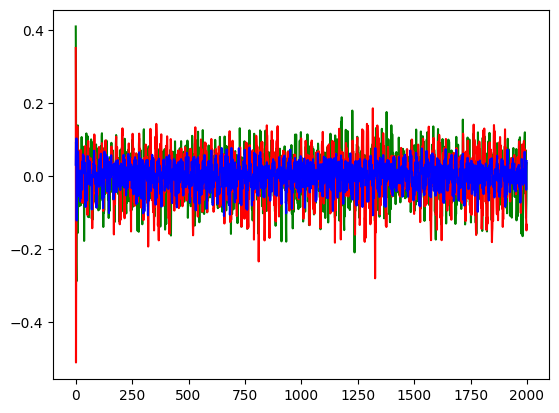

In [160]:
plt.plot(range(muestra_synt.shape[0]), RS4[0, 1:], color = 'green')
plt.plot(range(muestra_synt.shape[0]), RS4[1, 1:], color = 'red')
plt.plot(range(muestra_synt.shape[0]), RS4[2, 1:], color = 'blue')
plt.show()

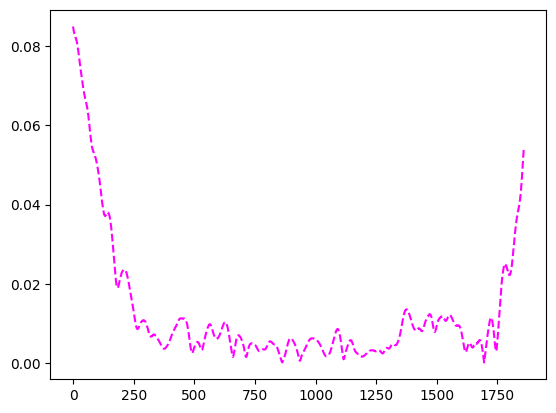

In [161]:
# Eliminamos los primeros puntos para estabilizar el reservorio
stable_start = min(90, amplitude_envelope4.shape[1])
input_sequence4 = amplitude_envelope4[:, stable_start:-50]
plt.plot(input_sequence4[0, 1:], linestyle="dashed", color = 'magenta')
plt.show()

In [162]:
# Agrupamiento (clustering)
num_clusters = 4  # Número de clústeres
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(input_sequence4.T)

# Resultados
idx = kmeans.labels_  # Etiquetas de los clústeres
C = kmeans.cluster_centers_  # Centroides de los clústeres

print("Centroides de los clústeres:")
print(C)
print(idx.shape)

Centroides de los clústeres:
[[0.00563167 0.01080831 0.01009002 0.00948316 0.0093582  0.00698237
  0.03526627 0.01237018 0.00786429 0.02586398 0.01725326 0.00596396
  0.01156521 0.024509   0.01841    0.01077471 0.00576142 0.00467794
  0.0063582  0.0354442 ]
 [0.06687585 0.00949143 0.25282509 0.20578014 0.07078125 0.16890728
  0.82682841 0.30222952 0.10960646 0.51697744 0.3633878  0.07125766
  0.23791836 0.60246257 0.02420695 0.03763257 0.00674415 0.05930468
  0.14864273 0.90324169]
 [0.00870308 0.02229734 0.0429764  0.03508963 0.02371594 0.02826596
  0.12585152 0.05155158 0.01608656 0.07355483 0.05434819 0.01229729
  0.03448876 0.09670908 0.03504597 0.0245016  0.01069412 0.00904388
  0.02637981 0.15357913]
 [0.03302068 0.02879192 0.11519345 0.09575844 0.03934558 0.07574324
  0.39071171 0.1394053  0.05091753 0.25902307 0.17703797 0.04253892
  0.1113906  0.27362595 0.06327429 0.03522965 0.01503051 0.03289844
  0.06743486 0.4016573 ]]
(1861,)


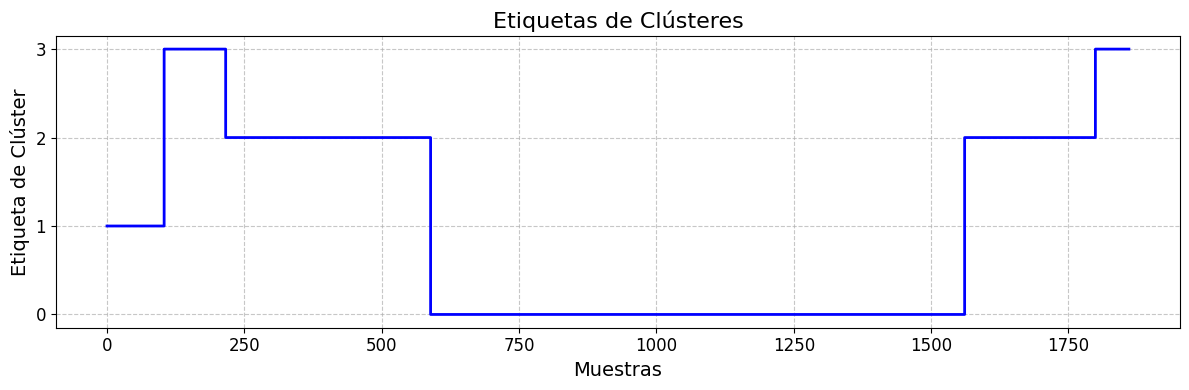

In [163]:
plt.figure(figsize=(12, 4))  
plt.step(range(input_sequence4.shape[1]), idx, where='post', color='blue', linewidth=2) 
plt.title('Etiquetas de Clústeres', fontsize=16)
plt.xlabel('Muestras', fontsize=14)  
plt.ylabel('Etiqueta de Clúster', fontsize=14)  
plt.yticks(np.arange(num_clusters))  
plt.xticks(fontsize=12)  
plt.yticks(fontsize=12)  
plt.grid(True, linestyle='--', alpha=0.7)  
#plt.xlim([0,200])
plt.tight_layout() 
plt.show()

### Versión cuántica.

In [164]:
# Hiperparámetros  
num_qubits = 10  # Ajustamos 10 qubit para cada canal 
dev = qml.device("default.qubit", wires=num_qubits)    
num_channels = 10 # tenemos 10 canales 


def quantum_reservoir(reservoir_weights, connectivity):  
    """Quantum Reservoir con compuertas CNOT y rotaciones."""  
    for i in range(num_qubits):  
         for j in range(num_qubits):  
            # Rotación aleatoria en cada qubit  
            qml.RX(reservoir_weights[i,j], wires= i)  

    # Aplicar entrelazamiento entre los qubits seleccionados.(conectividad limitada)  
    if connectivity == 'ring':  
        for j in range(num_qubits - 1):  
            qml.CNOT(wires=[j, j+1])  # Apply entanglement between adjacent qubits  


    if connectivity == 'star':  
    # Entangling the first qubit (central node) with all other qubits  
        central_qubit = 0  # We use qubit 0 as the central node  
        for j in range(1, num_qubits):  
             qml.CNOT(wires=[central_qubit, j])  

    if connectivity == 'random':  
            # Crear pares de qubits aleatorios  
              qubit_pairs = [(j, k) for j in range(num_qubits) for k in range(j + 1, num_qubits)]  
              random.shuffle(qubit_pairs)  
            # Entrelazar aleatoriamente  
              for j, k in qubit_pairs[:num_qubits // 2]:  
                  qml.CNOT(wires=[j, k])  

    elif connectivity == 'full':  
            # Full connectivity: entangle all pairs of qubits  
              for j in range(num_qubits):  
                 for k in range(j + 1, num_qubits):  # Loop over all pairs of qubits  
                    qml.CNOT(wires=[j, k])  # Apply entanglement between qubit j and k 


# Define Quantum Node
@qml.qnode(dev)
def quantum_echo_state_network(input_data, prev_output, weights_in, weights_rc, reservoir_weights):
    """Quantum Echo State Network (QESN)"""
    # Encode input and previous output into qubits
    for i in range(num_qubits):
        qml.RX(.05*weights_in[i] * input_data + .95*weights_rc[i] * prev_output[i], wires=i)
    
    # Evolve through the quantum reservoir
    quantum_reservoir(reservoir_weights, connectivity='full')
    
    # Measure expectation values (output features)
    return np.array([[qml.expval(qml.PauliZ(i))] for i in range(num_qubits)])

In [165]:
scaled_signal.shape

(2000, 10)

In [166]:
# Initialize parameters
weights_in = np.random.uniform(-np.pi, np.pi, num_qubits)
weights_rc = np.random.uniform(-np.pi, np.pi, num_qubits)
#reservoir_weights = np.random.uniform(-np.pi, np.pi, (num_qubits, num_qubits))
reservoir_weights = np.random.uniform(-np.pi, np.pi, (num_qubits, num_qubits))

input_series = scaled_signal
time_steps = input_series.shape[1]

# Run QESN
outputs = np.zeros((num_qubits, time_steps, num_channels))
prev_output = np.zeros(num_qubits)  # Initial output


for t0 in range(time_steps):
    q_output = quantum_echo_state_network(input_series[t0, :], prev_output, weights_in, weights_rc, reservoir_weights)
    final_output = np.tanh(q_output)  # Apply tanh non-linearity

    # Almacenar el resultado en la lista
    outputs[:, t0] = np.array(final_output)
    prev_output = final_output  # Recurrent connection
    print(f"Step {t0}, Channel {i+1}: {outputs[:, t0]}")

ValueError: can only convert an array of size 1 to a Python scalar

## Otra implementación cuántica.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from qiskit.quantum_info import random_unitary
from qiskit_aer import AerSimulator

from quantumreservoirpy.plot import feature_plotter
from quantumreservoirpy.reservoirs import Static

In [ ]:
secuencia.shape

In [ ]:
num_qubits = 5
operator = random_unitary(2 ** num_qubits, seed=417)
backend = AerSimulator()

In [ ]:
class QuantumReservoir(Static):

    def before(self, circuit):
        circuit.h(circuit.qubits)
    
    def during(self, circuit, timestep, reservoirnumber):
        circuit.initialize(int(timestep % 2), 1)
        circuit.append(operator, circuit.qubits)
        circuit.measure([0, 1])

In [ ]:
quantum_res = QuantumReservoir(n_qubits=num_qubits, backend=backend)
quantum_data = quantum_res.run(timeseries=secuencia, shots=10000)

In [ ]:
# Extracción de la envolvente superior usando Hilbert transform
RS_quant = quantum_data - np.mean(quantum_data,axis=1, keepdims=True)
print(RS_quant.shape)

plt.plot(t, RS_quant[:, 0], color = 'green')
plt.plot(t, RS_quant[:, 1], color = 'red')
plt.show()

In [ ]:
analytic_signal = hilbert(RS_quant)
amplitude_envelope = np.abs(analytic_signal)

# Eliminamos los primeros 75 puntos para estabilizar el reservorio
stable_start = min(75, analytic_signal.shape[0])
input_sequence = analytic_signal[stable_start:-50, :]
plt.plot(input_sequence[1:, 0], linestyle="dashed", color = 'magenta')
plt.show()

In [ ]:
# Agrupamiento (clustering)
num_clusters = 2  # Número de clústeres
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(input_sequence)

# Resultados
idx = kmeans.labels_  # Etiquetas de los clústeres
C = kmeans.cluster_centers_  # Centroides de los clústeres

print("Centroides de los clústeres:")
print(C)
print(idx.shape)

In [ ]:
plt.figure(figsize=(12, 4))  
plt.step(range(input_sequence.shape[0]), idx, where='post', color='blue', linewidth=2) 
plt.title('Etiquetas de Clústeres', fontsize=16)
plt.xlabel('Muestras', fontsize=14)  
plt.ylabel('Etiqueta de Clúster', fontsize=14)  
plt.yticks(np.arange(num_clusters))  
plt.xticks(fontsize=12)  
plt.yticks(fontsize=12)  
plt.grid(True, linestyle='--', alpha=0.7)
#plt.xlim(100, 200)  
plt.tight_layout() 
plt.show()